# Synthetic Data with interaction: recovery of relevant features

## Generate synthetic datasets

In [1]:
import torch
import numpy as np
from torch.distributions import MultivariateNormal
from ignite.utils import manual_seed

In [2]:
def jordan_se1(n_samples: int = 200, n_features: int = 2, rho: float = 0.0, noise_level: float = 0.1):
    features_indices = np.arange(1, n_features+1)
    col_indices, row_indices = np.meshgrid(features_indices, features_indices)
    power_matrix = np.abs(col_indices-row_indices)
    cov = torch.Tensor(rho**power_matrix)
    loc = torch.zeros(n_features)
    normal_dist = MultivariateNormal(loc, covariance_matrix=cov)
    X = normal_dist.sample((n_samples,))
    y_noise = X[:, 0] + noise_level * torch.randn(n_samples)
    y = y_noise.unsqueeze(-1)
    return X, y

### SE1

In [3]:
manual_seed(1000) # Visualization seed much higher to avoid biasing

In [4]:
X_se1, y_se1 = jordan_se1(rho=0.5)

#### Visualizing

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

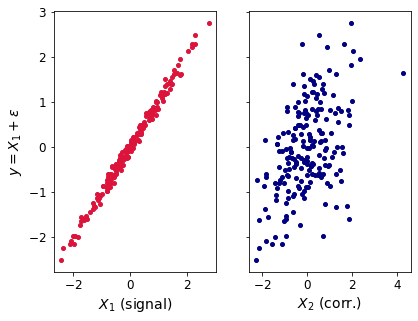

In [6]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_se1[:, 0], y_se1, 'o', markersize=4, color='crimson')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_se1[:, 1], y_se1, 'o', 
         markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
plt.show()

## Applying our method

In [7]:
import optuna
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.synthesizer import train_val_test_split

Define custom loss function

In [8]:
def ridge_loss(y_pred, y_true, model, reg_param):
    weights = model.rff_net[2].weight.squeeze()
    loss = torch.mean(torch.square(y_pred-y_true)) + reg_param * weights.dot(weights)
    return loss

Score function for early stopping

In [9]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

Optuna callback to save best model

In [10]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

### SE1

In [11]:
n_features = 2

In [12]:
train_size = 200
val_size = 100
test_size = 100

In [13]:
manual_seed(0)

In [14]:
X_se1, y_se1 = jordan_se1(n_samples=400, rho=0.5)

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se1, y_se1, train_size, val_size, test_size)

Generate datasets

In [16]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Prepare dataloaders

In [17]:
train_loader = DataLoader(train, batch_size=train_size)
val_loader = DataLoader(val, batch_size=val_size)
test_loader = DataLoader(test, batch_size=test_size)

Objective for optuna

In [18]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 50
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 300
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initalize optuna study

In [19]:
tpe_sampler = TPESampler(seed=0)

In [20]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-18 18:20:58,800] A new study created in memory with name: no-name-414d4684-9923-4482-8c8d-26952e755ec5


Run study

In [21]:
n_epochs = 1050

In [22]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 300 Loss: 0.24262
Validation - Epoch: 300 Loss: 0.44110
Learning rate: 0.0125
Training - Epoch: 600 Loss: 0.09442
Validation - Epoch: 600 Loss: 0.26533
Learning rate: 0.0063
Training - Epoch: 900 Loss: 0.06805
Validation - Epoch: 900 Loss: 0.22257
Learning rate: 0.0063


[I 2022-02-18 18:21:03,719] Trial 0 finished with value: 0.20721532821655272 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 0.0003766576841599299}. Best is trial 0 with value: 0.20721532821655272.


Training - Epoch: 300 Loss: 0.11518
Validation - Epoch: 300 Loss: 0.24157
Learning rate: 0.0161
Training - Epoch: 600 Loss: 0.04955
Validation - Epoch: 600 Loss: 0.14183
Learning rate: 0.0080
Training - Epoch: 900 Loss: 0.03903
Validation - Epoch: 900 Loss: 0.11872
Learning rate: 0.0080


[I 2022-02-18 18:21:05,985] Trial 1 finished with value: 0.1105690860748291 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 5.301709347576825e-05}. Best is trial 1 with value: 0.1105690860748291.


Training - Epoch: 300 Loss: 0.76054
Validation - Epoch: 300 Loss: 0.94193
Learning rate: 0.0070
Training - Epoch: 600 Loss: 0.48915
Validation - Epoch: 600 Loss: 0.66717
Learning rate: 0.0035
Training - Epoch: 900 Loss: 0.32355
Validation - Epoch: 900 Loss: 0.49393
Learning rate: 0.0035


[I 2022-02-18 18:21:08,191] Trial 2 finished with value: 0.42807807922363283 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 0.00016961746387290997}. Best is trial 1 with value: 0.1105690860748291.


Training - Epoch: 300 Loss: 0.68613
Validation - Epoch: 300 Loss: 0.85579
Learning rate: 0.0075
Training - Epoch: 600 Loss: 0.38333
Validation - Epoch: 600 Loss: 0.55592
Learning rate: 0.0038
Training - Epoch: 900 Loss: 0.25634
Validation - Epoch: 900 Loss: 0.44634
Learning rate: 0.0038


[I 2022-02-18 18:21:10,569] Trial 3 finished with value: 0.40800689697265624 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 0.0028765041432547}. Best is trial 1 with value: 0.1105690860748291.


Training - Epoch: 300 Loss: 0.02845
Validation - Epoch: 300 Loss: 0.10657
Learning rate: 0.0846
Training - Epoch: 600 Loss: 0.02048
Validation - Epoch: 600 Loss: 0.07714
Learning rate: 0.0423
Training - Epoch: 900 Loss: 0.01871
Validation - Epoch: 900 Loss: 0.06917
Learning rate: 0.0423


[I 2022-02-18 18:21:12,991] Trial 4 finished with value: 0.06616365909576416 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 8.264328927007728e-06}. Best is trial 4 with value: 0.06616365909576416.


Training - Epoch: 300 Loss: 0.04223
Validation - Epoch: 300 Loss: 0.19532
Learning rate: 0.0383
Training - Epoch: 600 Loss: 0.02471
Validation - Epoch: 600 Loss: 0.12649
Learning rate: 0.0192
Training - Epoch: 900 Loss: 0.02175
Validation - Epoch: 900 Loss: 0.10895
Learning rate: 0.0192


[I 2022-02-18 18:21:15,133] Trial 5 finished with value: 0.10257649421691895 and parameters: {'learning_rate': 0.03832216850492789, 'reg_param': 4.4103656679709824e-05}. Best is trial 4 with value: 0.06616365909576416.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:15,794] Trial 6 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.17421


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:16,404] Trial 7 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.80829


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:17,022] Trial 8 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.79896
Training - Epoch: 300 Loss: 0.06211
Validation - Epoch: 300 Loss: 0.19945
Learning rate: 0.0360
Training - Epoch: 600 Loss: 0.04200
Validation - Epoch: 600 Loss: 0.13532
Learning rate: 0.0180
Training - Epoch: 900 Loss: 0.03955
Validation - Epoch: 900 Loss: 0.12192
Learning rate: 0.0180


[I 2022-02-18 18:21:19,265] Trial 9 finished with value: 0.11735713005065918 and parameters: {'learning_rate': 0.0360009119291161, 'reg_param': 0.0022390342721683716}. Best is trial 4 with value: 0.06616365909576416.


Training - Epoch: 300 Loss: 0.02228
Validation - Epoch: 300 Loss: 0.10104
Learning rate: 0.0857
Training - Epoch: 600 Loss: 0.01732
Validation - Epoch: 600 Loss: 0.07161
Learning rate: 0.0428
Training - Epoch: 900 Loss: 0.01620
Validation - Epoch: 900 Loss: 0.06343
Learning rate: 0.0428


[I 2022-02-18 18:21:21,607] Trial 10 finished with value: 0.06034489154815674 and parameters: {'learning_rate': 0.08568943001593249, 'reg_param': 1.8580608579177215e-06}. Best is trial 10 with value: 0.06034489154815674.


Training - Epoch: 300 Loss: 0.02725
Validation - Epoch: 300 Loss: 0.09081
Learning rate: 0.0805
Training - Epoch: 600 Loss: 0.01933
Validation - Epoch: 600 Loss: 0.06431
Learning rate: 0.0402
Training - Epoch: 900 Loss: 0.01769
Validation - Epoch: 900 Loss: 0.05726
Learning rate: 0.0402


[I 2022-02-18 18:21:23,881] Trial 11 finished with value: 0.05461670875549316 and parameters: {'learning_rate': 0.08045564515992583, 'reg_param': 1.5966637752164484e-06}. Best is trial 11 with value: 0.05461670875549316.


Training - Epoch: 300 Loss: 0.02227
Validation - Epoch: 300 Loss: 0.08747
Learning rate: 0.0919
Training - Epoch: 600 Loss: 0.01717
Validation - Epoch: 600 Loss: 0.06380
Learning rate: 0.0460
Training - Epoch: 900 Loss: 0.01602
Validation - Epoch: 900 Loss: 0.05722
Learning rate: 0.0460


[I 2022-02-18 18:21:26,344] Trial 12 finished with value: 0.05472083568572998 and parameters: {'learning_rate': 0.09190131112923958, 'reg_param': 1.2746709967295589e-06}. Best is trial 11 with value: 0.05461670875549316.


Training - Epoch: 300 Loss: 0.05673
Validation - Epoch: 300 Loss: 0.18012
Learning rate: 0.0415
Training - Epoch: 600 Loss: 0.03151
Validation - Epoch: 600 Loss: 0.11874
Learning rate: 0.0208
Training - Epoch: 900 Loss: 0.02677
Validation - Epoch: 900 Loss: 0.10330
Learning rate: 0.0208


[I 2022-02-18 18:21:29,017] Trial 13 finished with value: 0.09763138771057128 and parameters: {'learning_rate': 0.041541631984713875, 'reg_param': 3.5907045454172474e-07}. Best is trial 11 with value: 0.05461670875549316.


Training - Epoch: 300 Loss: 0.02251
Validation - Epoch: 300 Loss: 0.09099
Learning rate: 0.0985
Training - Epoch: 600 Loss: 0.01736
Validation - Epoch: 600 Loss: 0.06590
Learning rate: 0.0493
Training - Epoch: 900 Loss: 0.01622
Validation - Epoch: 900 Loss: 0.05893
Learning rate: 0.0493


[I 2022-02-18 18:21:31,798] Trial 14 finished with value: 0.056278395652771 and parameters: {'learning_rate': 0.0985330508762059, 'reg_param': 2.2877915061639316e-06}. Best is trial 11 with value: 0.05461670875549316.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:32,463] Trial 15 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.80179
Training - Epoch: 300 Loss: 0.05062
Validation - Epoch: 300 Loss: 0.15668
Learning rate: 0.0279
Training - Epoch: 600 Loss: 0.02840
Validation - Epoch: 600 Loss: 0.10087
Learning rate: 0.0140
Training - Epoch: 900 Loss: 0.02431
Validation - Epoch: 900 Loss: 0.08747
Learning rate: 0.0140


[I 2022-02-18 18:21:34,942] Trial 16 finished with value: 0.08264783859252929 and parameters: {'learning_rate': 0.027914003168179154, 'reg_param': 7.766500089204422e-06}. Best is trial 11 with value: 0.05461670875549316.


Training - Epoch: 300 Loss: 0.03177
Validation - Epoch: 300 Loss: 0.11716
Learning rate: 0.0496
Training - Epoch: 600 Loss: 0.02143
Validation - Epoch: 600 Loss: 0.08031
Learning rate: 0.0248
Training - Epoch: 900 Loss: 0.01928
Validation - Epoch: 900 Loss: 0.07086
Learning rate: 0.0248


[I 2022-02-18 18:21:37,522] Trial 17 finished with value: 0.0673684024810791 and parameters: {'learning_rate': 0.049622270716823805, 'reg_param': 1.0131412885366678e-07}. Best is trial 11 with value: 0.05461670875549316.


Training - Epoch: 300 Loss: 0.06929
Validation - Epoch: 300 Loss: 0.16189
Learning rate: 0.0225
Training - Epoch: 600 Loss: 0.03647
Validation - Epoch: 600 Loss: 0.09950
Learning rate: 0.0113
Training - Epoch: 900 Loss: 0.03045
Validation - Epoch: 900 Loss: 0.08551
Learning rate: 0.0113


[I 2022-02-18 18:21:39,894] Trial 18 finished with value: 0.08060503959655761 and parameters: {'learning_rate': 0.022547342292471916, 'reg_param': 1.163582414256726e-05}. Best is trial 11 with value: 0.05461670875549316.


Training - Epoch: 300 Loss: 0.02722
Validation - Epoch: 300 Loss: 0.08022
Learning rate: 0.0613
Training - Epoch: 600 Loss: 0.01981
Validation - Epoch: 600 Loss: 0.05875
Learning rate: 0.0307
Training - Epoch: 900 Loss: 0.01817
Validation - Epoch: 900 Loss: 0.05293
Learning rate: 0.0307


[I 2022-02-18 18:21:42,194] Trial 19 finished with value: 0.050730500221252445 and parameters: {'learning_rate': 0.06130691967328132, 'reg_param': 7.081283695856133e-07}. Best is trial 19 with value: 0.050730500221252445.


Training - Epoch: 300 Loss: 0.03183
Validation - Epoch: 300 Loss: 0.08550
Learning rate: 0.0582
Training - Epoch: 600 Loss: 0.02202
Validation - Epoch: 600 Loss: 0.06108
Learning rate: 0.0291
Training - Epoch: 900 Loss: 0.01984
Validation - Epoch: 900 Loss: 0.05533
Learning rate: 0.0291


[I 2022-02-18 18:21:44,596] Trial 20 finished with value: 0.053226280212402347 and parameters: {'learning_rate': 0.05821123392171708, 'reg_param': 4.853851604547673e-07}. Best is trial 19 with value: 0.050730500221252445.


Training - Epoch: 300 Loss: 0.02831
Validation - Epoch: 300 Loss: 0.12273
Learning rate: 0.0533
Training - Epoch: 600 Loss: 0.02006
Validation - Epoch: 600 Loss: 0.08201
Learning rate: 0.0267
Training - Epoch: 900 Loss: 0.01833
Validation - Epoch: 900 Loss: 0.07166
Learning rate: 0.0267


[I 2022-02-18 18:21:46,992] Trial 21 finished with value: 0.06785547733306885 and parameters: {'learning_rate': 0.05334974445026626, 'reg_param': 4.7321281745956497e-07}. Best is trial 19 with value: 0.050730500221252445.


Training - Epoch: 300 Loss: 0.02772
Validation - Epoch: 300 Loss: 0.10992
Learning rate: 0.0604
Training - Epoch: 600 Loss: 0.01977
Validation - Epoch: 600 Loss: 0.07682
Learning rate: 0.0302
Training - Epoch: 900 Loss: 0.01809
Validation - Epoch: 900 Loss: 0.06808
Learning rate: 0.0302


[I 2022-02-18 18:21:49,350] Trial 22 finished with value: 0.06481631755828858 and parameters: {'learning_rate': 0.06043104268445745, 'reg_param': 1.0446933690540455e-07}. Best is trial 19 with value: 0.050730500221252445.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:50,065] Trial 23 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.07728
Training - Epoch: 300 Loss: 0.02861
Validation - Epoch: 300 Loss: 0.07803
Learning rate: 0.0659
Training - Epoch: 600 Loss: 0.02022
Validation - Epoch: 600 Loss: 0.05733
Learning rate: 0.0329
Training - Epoch: 900 Loss: 0.01843
Validation - Epoch: 900 Loss: 0.05182
Learning rate: 0.0329


[I 2022-02-18 18:21:52,383] Trial 24 finished with value: 0.04973392009735107 and parameters: {'learning_rate': 0.06588974155559381, 'reg_param': 8.383628817538226e-07}. Best is trial 24 with value: 0.04973392009735107.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:53,067] Trial 25 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.80027


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:53,741] Trial 26 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.04983
Training - Epoch: 300 Loss: 0.02703
Validation - Epoch: 300 Loss: 0.10309
Learning rate: 0.0675
Training - Epoch: 600 Loss: 0.01935
Validation - Epoch: 600 Loss: 0.07099
Learning rate: 0.0337
Training - Epoch: 900 Loss: 0.01774
Validation - Epoch: 900 Loss: 0.06289
Learning rate: 0.0337


[I 2022-02-18 18:21:56,124] Trial 27 finished with value: 0.05989655017852783 and parameters: {'learning_rate': 0.0674958772292958, 'reg_param': 8.472981746535955e-07}. Best is trial 24 with value: 0.04973392009735107.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:56,780] Trial 28 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.15937


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:57,504] Trial 29 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.15433


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:58,160] Trial 30 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.03109


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:58,824] Trial 31 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.02904


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:21:59,499] Trial 32 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.02689
Training - Epoch: 300 Loss: 0.02316
Validation - Epoch: 300 Loss: 0.10700
Learning rate: 0.0754
Training - Epoch: 600 Loss: 0.01740
Validation - Epoch: 600 Loss: 0.07127
Learning rate: 0.0377
Training - Epoch: 900 Loss: 0.01621
Validation - Epoch: 900 Loss: 0.06248
Learning rate: 0.0377


[I 2022-02-18 18:22:01,861] Trial 33 finished with value: 0.05925294399261474 and parameters: {'learning_rate': 0.07539120598830093, 'reg_param': 3.4204723048081694e-06}. Best is trial 24 with value: 0.04973392009735107.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:02,554] Trial 34 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.03390
Training - Epoch: 300 Loss: 0.02167
Validation - Epoch: 300 Loss: 0.09268
Learning rate: 0.0754
Training - Epoch: 600 Loss: 0.01727
Validation - Epoch: 600 Loss: 0.06659
Learning rate: 0.0377
Training - Epoch: 900 Loss: 0.01622
Validation - Epoch: 900 Loss: 0.05936
Learning rate: 0.0377


[I 2022-02-18 18:22:04,865] Trial 35 finished with value: 0.05662496566772461 and parameters: {'learning_rate': 0.07538311623863765, 'reg_param': 1.0119581290208076e-06}. Best is trial 24 with value: 0.04973392009735107.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:05,517] Trial 36 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.41075
Training - Epoch: 300 Loss: 0.02225
Validation - Epoch: 300 Loss: 0.10081
Learning rate: 0.0993
Training - Epoch: 600 Loss: 0.01917
Validation - Epoch: 600 Loss: 0.07401
Learning rate: 0.0497
Training - Epoch: 900 Loss: 0.01851
Validation - Epoch: 900 Loss: 0.06683
Learning rate: 0.0497


[I 2022-02-18 18:22:07,889] Trial 37 finished with value: 0.0641717529296875 and parameters: {'learning_rate': 0.09934651390982939, 'reg_param': 0.00030205233145781245}. Best is trial 24 with value: 0.04973392009735107.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:08,552] Trial 38 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.03270


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:22:09,245] Trial 39 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.03408


Get best model

In [23]:
best_model = study.user_attrs['best_model']

In [24]:
torch.save(best_model.state_dict(), '../models/jordan-se1.pth')

Replicate best model on different test datasets

In [25]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se1(n_samples=test_size, rho=0.5)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [26]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-18 18:22:09,276] A new study created in memory with name: no-name-8762e612-c05f-4d84-bc30-995effbb38ac


In [27]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-18 18:22:09,286] Trial 0 finished with value: 0.1314872323426671 and parameters: {}. Best is trial 0 with value: 0.1314872323426671.
[I 2022-02-18 18:22:09,290] Trial 1 finished with value: 0.21632284492063733 and parameters: {}. Best is trial 0 with value: 0.1314872323426671.
[I 2022-02-18 18:22:09,294] Trial 2 finished with value: 0.1366059104657259 and parameters: {}. Best is trial 0 with value: 0.1314872323426671.
[I 2022-02-18 18:22:09,297] Trial 3 finished with value: 0.15834789292837065 and parameters: {}. Best is trial 0 with value: 0.1314872323426671.
[I 2022-02-18 18:22:09,301] Trial 4 finished with value: 0.15253667890613276 and parameters: {}. Best is trial 0 with value: 0.1314872323426671.
[I 2022-02-18 18:22:09,305] Trial 5 finished with value: 0.14127154599491784 and parameters: {}. Best is trial 0 with value: 0.1314872323426671.
[I 2022-02-18 18:22:09,309] Trial 6 finished with value: 0.16657464188914112 and parameters: {}. Best is trial 0 with value: 0.13148

In [28]:
replication.trials_dataframe()['value'].mean()

0.15878725281436282

In [29]:
replication.trials_dataframe()['value'].std()

0.023917460065759007

#### Visualizing

##### Bands

In [30]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, 3)

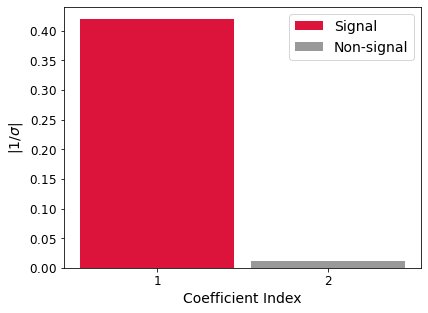

In [31]:
plt.bar(indexes[0], np.abs(bands)[0], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[1], np.abs(bands)[1], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks([1, 2])
plt.legend()
plt.show()

##### Predictions on test

In [32]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=2)
    (1): RandomFourierFeaturesLayer(in_features=2, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

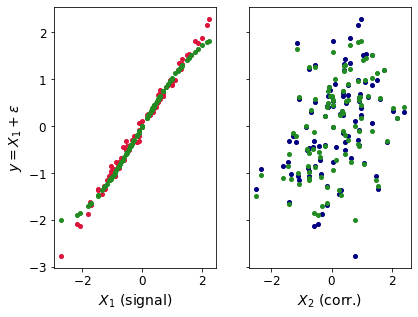

In [33]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax1.plot(X_test[:, 0], best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_test[:, 1], y_test, 'o', markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
ax2.plot(X_test[:, 1], best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.show()

In [34]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

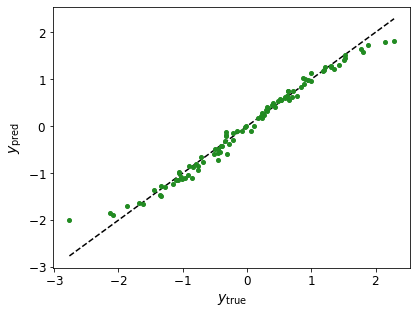

In [35]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()